In [12]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
import os
from typing import List, Tuple, Dict

from evaluate_prf1 import prf1_sweep, dir_is_inter_robot_lc, method_to_color

In [13]:
# results_dir = "/home/lucas/Workspace/sparse_mapping/segment_track/align/02_vio_10Hz"
# results_dir = "/home/masonbp/results/submap_align/kmd_outdoor/05_clip_6Hz"
results_dir = "/home/swarm/results/submap_align/kmd_outdoor/09_6Hz_voxel0.2"
# results_dir = "/home/lucas/Downloads/00_vio_6Hz/00_vio"
robots = ['sparkal1', 'sparkal2', 'acl_jackal', 'acl_jackal2', 'thoth', 'hathor']
# line_styles = [':', '--', '-.']
line_styles = ['-']
# methods = ["00_semanticvolgrav", "01_sig_0.2_eps_0.4"]
# methods = ["00_semanticvolgrav"]
# methods = ["svg_r15", 'svg_r20', 'evg_r15,', "pvg_cos_r15", "pvg_r15", "svg_r15_veps_0.2", "prunevolgrav"]
# methods = ["svg", "spvg", "spvg_min_cos_0.85", "pvg", "prune", "spvg_min_cos_0.85_sig0.3", "spvg_min_cos_0.85_c15", "spvg_min_cos_0.85_voxelvol"] #, "spvg", "pvg", "prune"]
methods = ["spvg_min_cos_0.85", "pvg", "prunevolgrav_fr", "ransac_100K", "ransac_1M", "point3d", "semanticgrav", "gravity", "product", "arithmetic_mean"]
# methods = ["spvg_min_cos_0.85", "spvg_eps_0.1"]

# comparison methods
comparison_methods = ["spvg_min_cos_0.85", "ransac_100K", "ransac_1M", "point3d", "prunevolgrav_fr"]

# parts add ins
ablation_methods = ["point3d", "gravity", "semanticgrav", "spvg_min_cos_0.85"]
names = {"point3d": "Point Only", "gravity": "+ Gravity", "semanticgrav": "+ Semantics", "spvg_min_cos_0.85": "+ PCA/Volume"}

# parts add ins
ablation_methods = ["point3d", "product", "arithmetic_mean", "spvg_min_cos_0.85"]
names = {"point3d": "Point Only", "spvg_min_cos_0.85": "Geometric Mean"}

methods = ablation_methods

names = {
    "svg_r15": "semantic/vol/grav, vol eps=0.2",
    "evg_r15,": "extent/vol/grav",
    "pvg_r15": "pca/vol/grav",
    "prunevolgrav": "prune vol/grav",
    "svg_vol_eps_0.0": "semantics/vol/grav",
    "spvg": "semantics/pca/vol/grav",
    "spvg_min_cos_0.85": "ROMAN",
    "svg": "semantic/vol/grav",
    "pvg": "ROMAN w/o semantics",
    "prune": "CLIPPER",
    "prunevolgrav_fr": "CLIPPER + Prune",
    "ransac_100K": "RANSAC-100K",
    "ransac_1M": "RANSAC-1M",
    "point3d": "CLIPPER"
}

# DSTA plot
# methods = ["spvg_min_cos_0.85", "ransac_100K", "ransac_1M", "point3d"]
# names = {
#     "spvg_min_cos_0.85": "ROMAN", #"gravity + shape + semantics",
#     "ransac_100K": "RANSAC w/ 100K iterations",
#     "ransac_1M": "RANSAC w/ 1M iterations",
#     "point3d": "PUMA"
# }
sub_dirs = [x[0] for x in os.walk(results_dir)][1:]
req_overlap = 2/3


In [14]:
def plot_success_rate(methods: List[str], percent_correct: Dict[str, List[float]], req_err_ang_dist_pairs: np.array, full_names={}, colors={}, styles={}, legend=True, dist_only=True):
    ax = plt.gca()
    
    for method in methods:
        # set the seed with the method name
        np.random.seed((hash(method)) % 2**32)
        
        if method not in full_names:
            full_names[method] = method
        if method not in colors:
            colors[method] = method_to_color(method)
        if method not in styles:
            styles[method] = np.random.choice(line_styles)
    
    for i, method in enumerate(methods):
        if dist_only:
            ax.plot(req_err_ang_dist_pairs[:,1], percent_correct[method], label=full_names[method], linestyle=styles[method], color=colors[method])
        else:
            ax.plot(req_err_ang_dist_pairs[:,0], percent_correct[method], label=full_names[method], linestyle=styles[method], color=colors[method])

    ax.set_ylabel('Alignment Success Rate')
    if dist_only:
        ax.set_xlabel('Distance Error Threshold (m)')
    else:
        ax.set_xlabel('Angular Error Threshold (deg)')
        ax_cp = ax.twiny()
        ax_cp.set_xlim(ax.get_xlim())
        ax_cp.set_xticks(req_err_ang_dist_pairs[:,0])
        ax_cp.set_xticklabels(req_err_ang_dist_pairs[:,1])
        ax_cp.set_xlabel('Distance Error Threshold (m)')
    if legend:
        ax.legend()
    
def reg_accuracy_sweep(pkl_paths, req_overlap=0.5, go_up_to_5=False, min_angle=60.0, max_angle=180.0):
    load_success = False
    for i, pkl_path in enumerate(pkl_paths):
        try:
            pkl_file = open(pkl_path, 'rb')
        except:
            print(f"Could not open {pkl_path}")
            continue
        if not load_success:
            load_success = True
            overlap_mat, err_ang_mat, err_dist_mat, num_assoc_mat, yaw_diff_mat = pickle.load(pkl_file)
            overlap_mat = np.reshape(overlap_mat, (-1,1))
            err_ang_mat = np.reshape(err_ang_mat, (-1,1))
            err_dist_mat = np.reshape(err_dist_mat, (-1,1))
            num_assoc_mat = np.reshape(num_assoc_mat, (-1,1))
            yaw_diff_mat = np.reshape(yaw_diff_mat, (-1,1))
        else:
            om, eam, edm, nam, ydm = pickle.load(pkl_file)
            overlap_mat = np.concatenate((overlap_mat, np.reshape(om, (-1,1))), axis=0)
            err_ang_mat = np.concatenate((err_ang_mat, np.reshape(eam, (-1,1))), axis=0)
            err_dist_mat = np.concatenate((err_dist_mat, np.reshape(edm, (-1,1))), axis=0)
            num_assoc_mat = np.concatenate((num_assoc_mat, np.reshape(nam, (-1,1))), axis=0)
            yaw_diff_mat = np.concatenate((yaw_diff_mat, np.reshape(ydm, (-1,1))), axis=0)
    
    if not load_success:
        raise FileNotFoundError("Could not load any of the pkl files")
    req_err_ang_dist_pairs = np.array([
        # (0.25, 0.125),
        (0.5, 0.25),
        (1.0, 0.5),
        (1.5, 0.75),
        (2.0, 1.0),
        (2.5, 1.25),
        (3.0, 1.5),
    ])
    if go_up_to_5:
        req_err_ang_dist_pairs = np.concatenate((req_err_ang_dist_pairs, np.array([
            (4.0, 2.0),
            (5.0, 2.5),
            (6.0, 3.0),
            (7.0, 3.5),
            (8.0, 4.0),
            (9.0, 4.5),
            (10.0, 5.0),
        ])))
    
    correct_loc = []
    relevant_alignments = np.bitwise_and(np.bitwise_and(
        overlap_mat > req_overlap, yaw_diff_mat > min_angle), yaw_diff_mat < max_angle)
    total_loc = np.sum(relevant_alignments)
    for req_err_ang, req_err_dist in req_err_ang_dist_pairs:
        correct_loc.append(np.sum(relevant_alignments & (err_ang_mat < req_err_ang) & (err_dist_mat < req_err_dist)))
        # correct_loc.append(np.sum(np.bitwise_and(np.bitwise_and(relevant_alignments, (err_ang_mat < req_err_ang)), (err_dist_mat < req_err_dist))))
    
    return (np.array(correct_loc) / total_loc), total_loc, req_err_ang_dist_pairs

In [15]:
success_rate = dict()
for method in methods:
    pkl_paths = [f"{sub_dir}/{method}.pkl" for sub_dir in sub_dirs if not dir_is_inter_robot_lc(sub_dir)]
    to_rm = []
    # for i, sd in enumerate(sub_dirs):
    #     robot_combinations = sd.split('/')[-1]
    #     for robot in robots:
    #         if robot_combinations.count(robot) == 2:
    #             to_rm.append(i)
    #             break
    # for i in sorted(to_rm, reverse=True):
    #     del pkl_paths[i]

    try:
        pc_meth, total_loc, req_err_ang_dist_pairs = reg_accuracy_sweep(
            pkl_paths, req_overlap=req_overlap, go_up_to_5=True, min_angle=60.0, max_angle=180.0)
        success_rate[method] = pc_meth
    except FileNotFoundError:
        print(f"Failed to load {method}")

print(success_rate)

{'point3d': array([0.        , 0.        , 0.        , 0.        , 0.01709402,
       0.01709402, 0.01709402, 0.02564103, 0.02564103, 0.05128205,
       0.06837607, 0.06837607, 0.07692308]), 'product': array([0.        , 0.00854701, 0.00854701, 0.03418803, 0.04273504,
       0.04273504, 0.06837607, 0.07692308, 0.11111111, 0.11111111,
       0.11111111, 0.11111111, 0.13675214]), 'arithmetic_mean': array([0.        , 0.        , 0.        , 0.        , 0.01709402,
       0.01709402, 0.03418803, 0.04273504, 0.04273504, 0.05982906,
       0.06837607, 0.07692308, 0.08547009]), 'spvg_min_cos_0.85': array([0.        , 0.01709402, 0.05982906, 0.09401709, 0.11111111,
       0.11965812, 0.15384615, 0.18803419, 0.22222222, 0.23076923,
       0.23076923, 0.23076923, 0.23931624])}


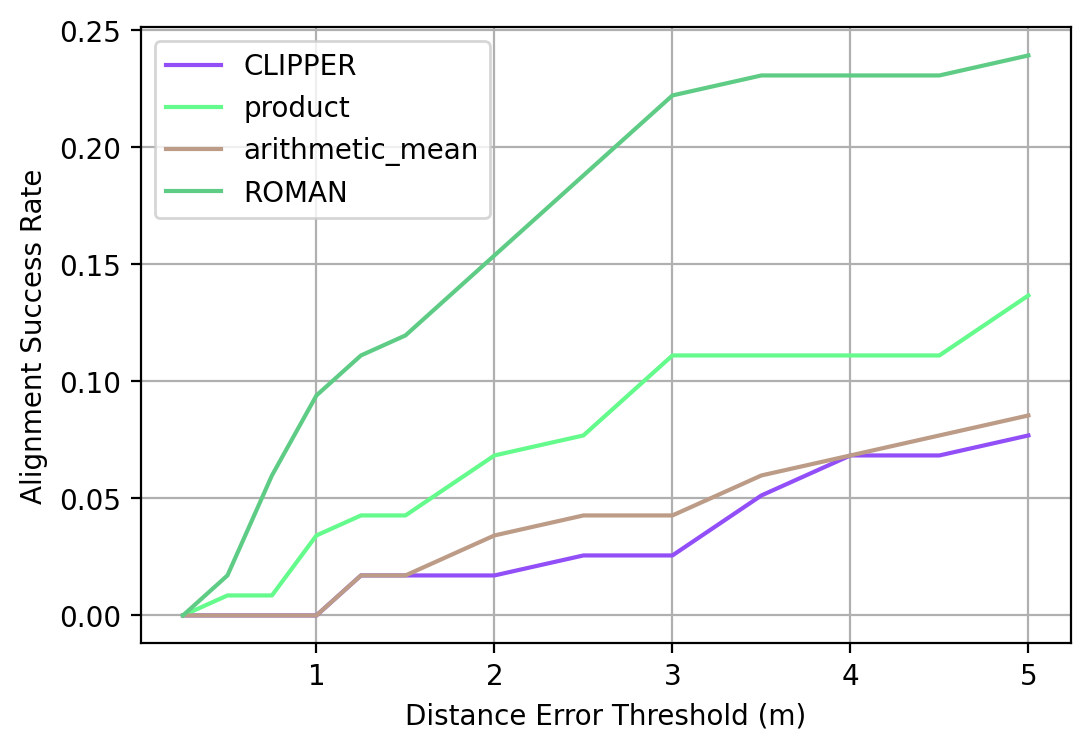

In [16]:
fig, ax = plt.subplots(dpi=200, figsize=(6,4))

found_methods = [method for method in methods if method in success_rate]
plot_success_rate(found_methods, success_rate, req_err_ang_dist_pairs, legend=True, full_names=names)
# ax.set_xlabel('Recall')
# ax.set_ylabel('Precision')
ax.legend()
ax.grid()
# plt.show()
# plt.savefig("/home/masonbp/figs/outdoor_global_loc_rss24/kmd_pr.pdf")
plt.show()